# Arbitrage pricing theory 
(Reference : https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Arbitrage_Pricing_Theory/notebook.ipynb )

  Arbitrage pricing theory is a major asset pricing theory that relies on expressing the returns using a linear factor model:

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$
This theory states that if we have modelled our rate of return as above, then the expected returns obey

$$ E(R_i) = R_F + b_{i1} \lambda_1 + b_{i2} \lambda_2 + \ldots + b_{iK} \lambda_K $$

where $R_F$ is the risk-free rate, and $\lambda_j$ is the risk premium - the return in excess of the risk-free rate - for factor $j$. 

--> $\lambda_j$ --> Risk Premiun for Factor j --> (Return_factor - Risk Free Interest Rate)

This premium arises because investors require higher returns to compensate them for incurring risk (More Risk More Return). 

This generalizes the capital asset pricing model (CAPM), which uses the return on the market as its only factor.

We can compute $\lambda_j$ by constructing a portfolio that has a sensitivity of 1 to factor $j$ and 0 to all others (called a pure factor portfolio for factor $j$), 

and measure its return in excess of the risk-free rate. 

Alternatively, we could compute the factor sensitivities for $K$ well-diversified (no asset-specific risk, i.e. $\epsilon_p = 0$) 


portfolios, and then solve the resulting system of linear equations.

In [1]:
# basic
import numpy as np
import pandas as pd 
import datetime as dt 
from pandas_datareader import data as pdr 

# regression
import  statsmodels.api  as sm 

# optimization 
from scipy.optimize import minimize

# visulization
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

# Arbitrage

There are generally many, many securities in our universe. If we use different ones to compute the $\lambda$ , will our results be consistent? 

If our results are inconsistent, there is an arbitrage opportunity (in expectation). 

Arbitrage is an operation that earns a profit without incurring risk and with no net investment of money, and an arbitrage opportunity is an opportunity to conduct such an operation. 

In this case, we mean that there is a risk-free operation with expected positive return that requires no net investment. 

It occurs when expectations of returns are inconsistent, i.e. risk is not priced consistently across securities.

For instance, there is an arbitrage opportunity in the following case: 

--> say there is an asset with expected rate of return 0.2 for the next year and a $\beta$ of 1.2 with the market, 

while the market is expected to have a rate of return of 0.1 , and the risk-free rate on 1-year bonds is 0.05. 

Then the APT model tells us that the expected rate of return on the asset should be

$$ R_F + \beta \lambda = 0.05 + 1.2 (0.1 - 0.05) = 0.11 $$ 

$$ --> R_f + Market_{Beta} *  (Market_{Return} - R_f) $$ 

This does not agree with the prediction that the asset will have a rate of return of 0.2 --> ( (APT model)0.11 != 0.2(Expected Return) )

So, if we 

buy \$100 of our asset, 

short \$120 of the market, 

and buy \$20 of bonds,  --> (buy:120(100+20) , short :120) 

we will have invested no net money and are not exposed to any systematic risk (we are market-neutral), 

but we expect to earn 


$$ 0.2 \cdot 100 - 0.1 \cdot 120 + 20 \cdot 0.05 = 9 $$

$$ Asset_{ER} * 100  - ( 1.2 * 100 ) * 0.1 + 20 * 0.05 $$

dollars at the end of the year.

The APT assumes that these opportunities will be taken advantage of until prices shift and the arbitrage opportunities disappear. 

That is, it assumes that there are arbitrageurs who have sufficient amounts of patience and capital. 

This provides a justification for the use of empirical factor models in pricing securities: if the model were inconsistent, 

there would be an arbitrage opportunity, and so the prices would adjust.



# --> Next Let's Compute the Expected Return 

In [16]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF



# ------------ Company_DF parameters ------------ 
# Market --> SPY

start   = dt.datetime(2015,1,1)
end     = dt.datetime(2015,6,30)
tickers = ["HSC","MSFT","SPY",'BIL']

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF

,HSC,MSFT,SPY,BIL
Date,,,,
2014-12-31,18.889999,46.450001,205.539993,91.480003
2015-01-02,18.600000,46.759998,205.429993,91.459999
2015-01-05,17.870001,46.330002,201.720001,91.480003
2015-01-06,17.350000,45.650002,199.820007,91.459999
2015-01-07,17.420000,46.230000,202.309998,91.459999
...,...,...,...,...
2015-06-24,17.000000,45.639999,210.500000,91.400002
2015-06-25,16.690001,45.650002,209.860001,91.419998
2015-06-26,16.730000,45.259998,209.820007,91.400002


In [17]:
class Ken_French_Library():
    """
    Fama/French 3 Factors [Weekly]
    Fama/French 3 Factors [Daily]
    """

    def __init__(self,start,periods):

        self.start = start 
        self.periods = periods
    
    def get_data(self):

        research_factors = pdr.DataReader('F-F_Research_Data_Factors_'+str(self.periods),
                                      'famafrench', start=self.start)[0] 
        momentum_factor = pdr.DataReader('F-F_Momentum_Factor_daily',
                                     'famafrench', start=self.start)[0]

        five_factors = research_factors.join(momentum_factor).dropna()
        five_factors /= 100.
        five_factors.index = five_factors.index.tz_localize('utc')

        five_factors.columns = five_factors.columns.str.strip()

        self.five_factors = pd.DataFrame(five_factors)
        self.five_factors = self.five_factors.reset_index()
        self.five_factors['Date'] = self.five_factors.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        self.five_factors.index   = self.five_factors['Date']
        self.five_factors = self.five_factors.drop(['Date'],axis=1)
        
        return self.five_factors
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        

    def __len__(self):
        return self.five_factors.shape[0]

Fama_French =  Ken_French_Library(start=dt.datetime(2015,1,1),periods='Daily')
FF_DF       =  Fama_French.get_data()
FF_DF

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2015-01-02,-0.0012,-0.0060,0.0008,0.0,-0.0010
2015-01-05,-0.0184,0.0034,-0.0068,0.0,0.0119
2015-01-06,-0.0104,-0.0078,-0.0030,0.0,0.0048
2015-01-07,0.0119,0.0018,-0.0064,0.0,0.0093
2015-01-08,0.0181,-0.0012,-0.0028,0.0,0.0012
...,...,...,...,...,...
2021-06-24,0.0068,0.0062,0.0023,0.0,0.0071
2021-06-25,0.0032,-0.0068,0.0046,0.0,-0.0058
2021-06-28,0.0023,-0.0048,-0.0159,0.0,0.0011


In [18]:
def Multi_Assets_with_FF(Stock_DF,Fama_French_DF,Return=None):
    
    if Return:
        Output_DF  = Stock_DF.pct_change().reset_index()
        Output_DF  = Output_DF.dropna()
    else:
        Output_DF = Stock_DF.reset_index()
        
    # set index
    Output_DF.index = Output_DF['Date']
    Output_DF = Output_DF.drop(['Date'],axis=1)
    Output_DF = pd.merge(Output_DF,Fama_French_DF,how='inner',left_index=True, right_index=True)

    return Output_DF


regression_df = Multi_Assets_with_FF(Stock_DF=Stock_DF,Fama_French_DF=FF_DF,Return=True)
current_RF    = regression_df['RF'][-1] # for constructing CAL 
regression_df

,HSC,MSFT,SPY,BIL,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,,,
2015-01-02,-0.015352,0.006674,-0.000535,-0.000219,-0.0012,-0.0060,0.0008,0.0,-0.0010
2015-01-05,-0.039247,-0.009196,-0.018060,0.000219,-0.0184,0.0034,-0.0068,0.0,0.0119
2015-01-06,-0.029099,-0.014677,-0.009419,-0.000219,-0.0104,-0.0078,-0.0030,0.0,0.0048
2015-01-07,0.004035,0.012705,0.012461,0.000000,0.0119,0.0018,-0.0064,0.0,0.0093
2015-01-08,0.035017,0.029418,0.017745,0.000000,0.0181,-0.0012,-0.0028,0.0,0.0012
...,...,...,...,...,...,...,...,...,...
2015-06-24,0.004728,-0.005881,-0.007263,0.000000,-0.0079,-0.0012,0.0012,0.0,0.0000
2015-06-25,-0.018235,0.000219,-0.003040,0.000219,-0.0025,0.0037,-0.0021,0.0,0.0090
2015-06-26,0.002397,-0.008543,-0.000191,-0.000219,-0.0006,-0.0021,0.0042,0.0,0.0001


In [22]:
def OLS_Linear_Regression(y,x):

    # linear Regression
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    res   = model.fit()

    # Print Summary
    print(res.summary())

    return res


Asset_1 = regression_df['HSC'].values
Asset_2 = regression_df['MSFT'].values 
x = sm.add_constant( regression_df[['SPY','BIL']].values )

print("Result for HSC : \n")
Asset_1_ressult = OLS_Linear_Regression(y=Asset_1,x=x)
print("Result for MSFT : \n")
Asset_2_ressult = OLS_Linear_Regression(y=Asset_2,x=x)

Result for HSC : 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     38.36
Date:                Sun, 29 Aug 2021   Prob (F-statistic):           1.25e-13
Time:                        13:55:34   Log-Likelihood:                 331.49
No. Observations:                 124   AIC:                            -657.0
Df Residuals:                     121   BIC:                            -648.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002 

In [53]:
import statsmodels.api as sm 


ticker_1 = 'MSFT'
ticker_2 = "HSC"

Factors = ['SPY','BIL']

def Rolling_Beta(regression_df,ticker,Factors,window):

    Y_rolling = regression_df[ticker].rolling(window=window)
    X_rolling = regression_df[Factors].rolling(window=window)

    Factor_Beta = pd.DataFrame()
    Index = []
    Cols_Factor = [ str(factor) + " Beta" for factor in Factors]

    for x,y in zip(X_rolling,Y_rolling) :

        x = sm.add_constant(x.values)
        index = y.index[-1]
        y = y.values 

        if x.shape[0] >= 30 : 

            Index.append(index)
            model  = sm.OLS(y,x)
            res    =  model.fit()
            params = res.params
            params = pd.Series(params)
            Factor_Beta = Factor_Beta.append(params,ignore_index=True)


    cols = ['Alpha']
    cols.extend(Cols_Factor)
    Factor_Beta.columns = cols
    Factor_Beta.index   = Index

    return Factor_Beta

Asset_1 = Rolling_Beta(regression_df,ticker_1,Factors,window=30)
Asset_2 = Rolling_Beta(regression_df,ticker_2,Factors,window=30)

Asset_1


,Alpha,SPY Beta,BIL Beta
2015-02-13,-0.002956,1.753100,-6.754769
2015-02-17,-0.003469,1.748736,-3.247506
2015-02-18,-0.004780,2.016849,-19.727164
2015-02-19,-0.004772,2.027044,-17.699730
2015-02-20,-0.004647,2.055453,-16.743133
...,...,...,...
2015-06-24,-0.001405,1.462646,-5.867038
2015-06-25,-0.001385,1.440443,-4.523774
2015-06-26,-0.001938,1.337636,-1.499581
2015-06-29,-0.001467,1.196325,0.084002


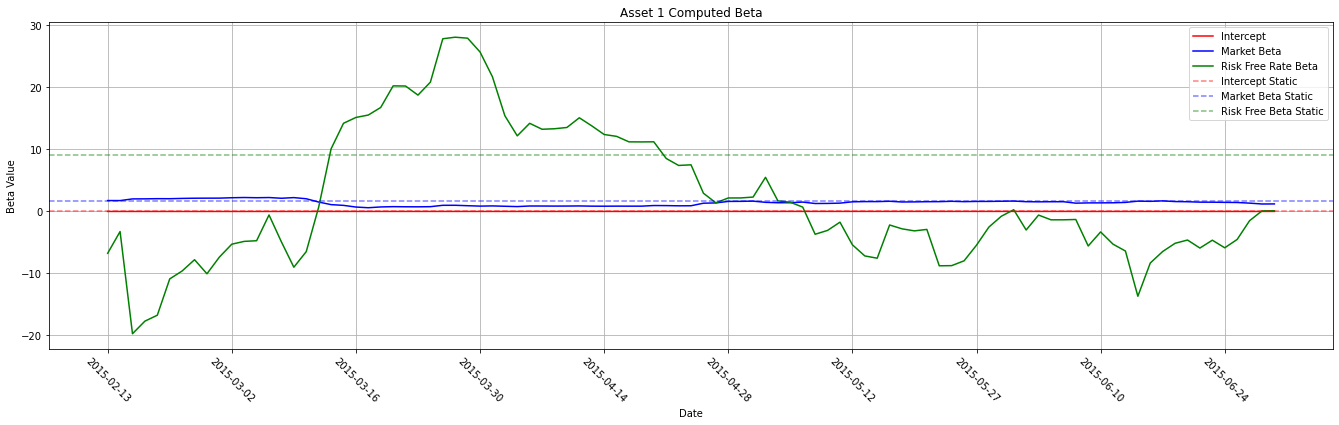

In [52]:
fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Asset 1 Computed Beta')
ax.plot(Asset_1.index,Asset_1.Alpha,label='Intercept',color='red')
ax.plot(Asset_1.index,Asset_1['SPY Beta'],label='Market Beta',color='blue')
ax.plot(Asset_1.index,Asset_1['BIL Beta'],label='Risk Free Rate Beta',color='green')

# Current Fixed parameters 

ax.axhline(Asset_1_ressult.params[0],label='Intercept Static',linestyle='--',color='red',alpha=0.5) 
ax.axhline(Asset_1_ressult.params[1],label='Market Beta Static',linestyle='--',color='blue',alpha=0.5) 
ax.axhline(Asset_1_ressult.params[2],label='Risk Free Beta Static',linestyle='--',color='green',alpha=0.5) 

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.set_ylabel('Beta Value')
ax.set_xlabel('Date')
plt.xticks(rotation=-45)
plt.legend()
plt.grid()


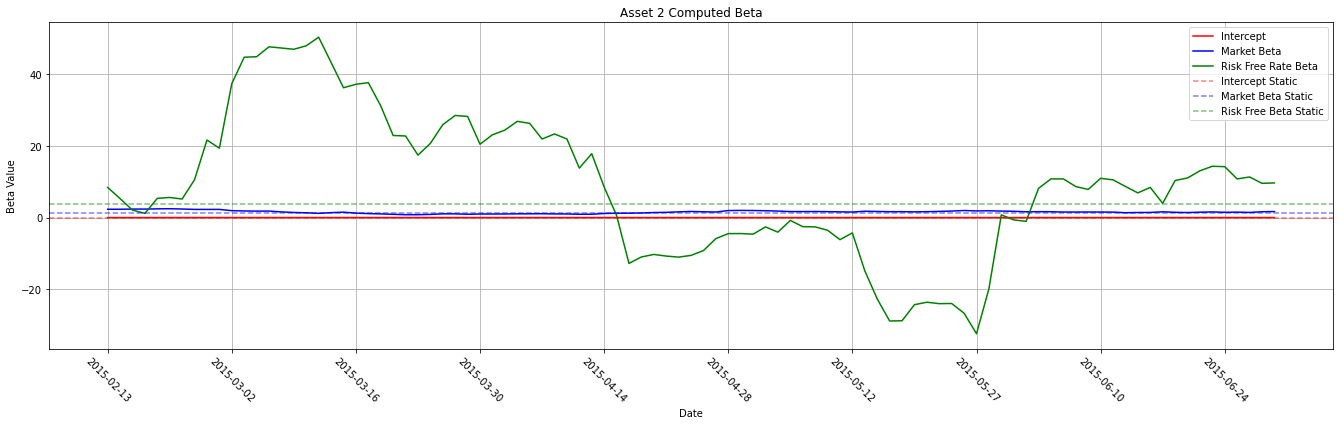

In [55]:
fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Asset 2 Computed Beta')
ax.plot(Asset_2.index,Asset_2.Alpha,label='Intercept',color='red')
ax.plot(Asset_2.index,Asset_2['SPY Beta'],label='Market Beta',color='blue')
ax.plot(Asset_2.index,Asset_2['BIL Beta'],label='Risk Free Rate Beta',color='green')

# Current Fixed parameters 

ax.axhline(Asset_2_ressult.params[0],label='Intercept Static',linestyle='--',color='red',alpha=0.5) 
ax.axhline(Asset_2_ressult.params[1],label='Market Beta Static',linestyle='--',color='blue',alpha=0.5) 
ax.axhline(Asset_2_ressult.params[2],label='Risk Free Beta Static',linestyle='--',color='green',alpha=0.5) 

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.set_ylabel('Beta Value')
ax.set_xlabel('Date')
plt.xticks(rotation=-45)
plt.legend()
plt.grid()

# Goes Both Ways

Often knowing $E(R_i)$ is incredibly difficult, but notice that this model tells us what the expected returns should be if the market is fully arbitraged. 

This lays the groundwork for long-short equity strategies based on factor model ranking systems. 

If you know what the expected return of an asset is given that the market is arbitraged, 

and you hypothesize that the market will be mostly arbitraged over the timeframe on which you are trading, then you can construct a ranking.

# Long-Short Equity

To do this, estimate the expected return for each asset on the market, then rank them. 

Long the top percentile and short the bottom percentile, and you will make money on the difference in returns. 

Said another way, if the assets at the top of the ranking on average tend to make $5\%$ more per year than the market, 

and assets at the bottom tend to make $5\%$ less, 

then you will make 

$ (M + 0.05) - (M - 0.05) = 0.10$ or $10\%$ 

percent per year, 

where $M$ is the market return that gets canceled out.

Long-short equity accepts that any individual asset is very difficult to model, relies on broad trends holding true. 

We can't accurately predict expected returns for an asset, but we can predict the expected returns for a group of 1000 assets as the errors average out.

We will have a full lecture on long-short models later.

# Predicting the Future Return With APT Model

Let's use this model to predict future prices for these assets

In [58]:
Asset_1_ressult.params

# ------------ Company_DF parameters ------------ 
# Market --> SPY

start   = dt.datetime(2015,7,1)
end     = dt.datetime(2015,12,31)
tickers = ["HSC","MSFT","SPY",'BIL']

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF


,HSC,MSFT,SPY,BIL
Date,,,,
2015-06-30,16.500000,44.150002,205.850006,91.419998
2015-07-01,17.760000,44.450001,207.500000,91.419998
2015-07-02,17.730000,44.400002,207.309998,91.419998
2015-07-06,17.260000,44.389999,206.720001,91.419998
2015-07-07,16.809999,44.299999,208.020004,91.400002
...,...,...,...,...
2015-12-24,8.250000,55.669998,205.679993,91.379997
2015-12-28,7.880000,55.950001,205.210007,91.360001
2015-12-29,7.990000,56.549999,207.399994,91.360001


Text(0, 0.5, 'Return')

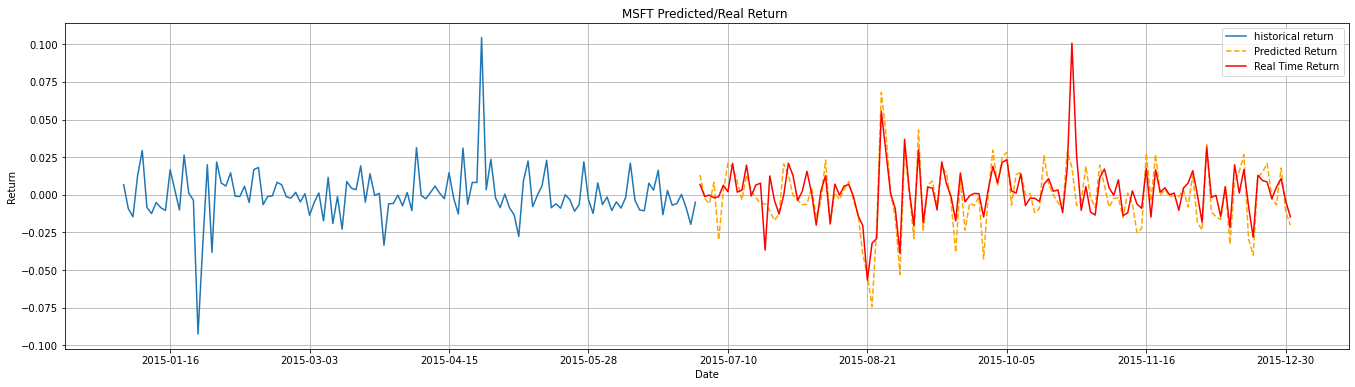

In [80]:
x = Stock_DF[["SPY",'BIL']].pct_change().dropna()
x = sm.add_constant(x)
predicted_return = np.dot(x.values,Asset_1_ressult.params)
real_return = Stock_DF['MSFT'].pct_change().dropna()


fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('MSFT Predicted/Real Return ')

ax.plot(regression_df.index,regression_df['MSFT'],label='historical return')
ax.plot(Stock_DF.index[1:],predicted_return,label='Predicted Return',linestyle='--',color='orange')
ax.plot(Stock_DF.index[1:],real_return     ,label='Real Time Return',color='red')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.grid()
plt.legend()

ax.set_xlabel('Date')
ax.set_ylabel('Return')
